In [2]:
# Import python library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
# Load dataset
file_path = 'scores_data.csv'
df = pd.read_csv(file_path)
pd.set_option('display.max_columns',150)
print(df.shape)

(149, 3)


In [11]:
# Clean column names and data
df.columns = df.columns.str.strip()
df['Batch'] = df['Batch'].str.strip()
df['User_ID'] = df['User_ID'].str.strip()
df['Score'] = df['Score'].str.strip()

In [12]:
# Extract numeric score
df['numeric_score'] = df['Score'].str.split('/').str[0].str.strip().astype(int)
df['percentage'] = (df['numeric_score'] / 7) * 100

In [13]:
# ML TEST SCORES ANALYSIS - COMPREHENSIVE INSIGHTS

In [15]:
# DESCRIPTIVE STATISTICS BY BATCH
batch_stats = df.groupby('Batch')['numeric_score'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std_Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(2)
print(batch_stats)

            Count  Mean  Median  Std_Dev  Min  Max   Q1    Q3
Batch                                                        
AI_ELITE_4     48  3.79     4.0     1.44    0    7  3.0  4.25
AI_ELITE_6     48  4.23     4.0     1.64    0    7  3.0  5.00
AI_ELITE_7     53  5.06     5.0     1.45    2    7  4.0  6.00


In [16]:
# PERFORMANCE DISTRIBUTION
for batch in df['Batch'].unique():
    batch_data = df[df['Batch'] == batch]['numeric_score']
    print(f"\n{batch}:")
    score_dist = batch_data.value_counts().sort_index()
    for score, count in score_dist.items():
        pct = (count / len(batch_data)) * 100
        print(f"  Score {score}: {count} students ({pct:.1f}%)")


AI_ELITE_7:
  Score 2: 2 students (3.8%)
  Score 3: 7 students (13.2%)
  Score 4: 10 students (18.9%)
  Score 5: 11 students (20.8%)
  Score 6: 13 students (24.5%)
  Score 7: 10 students (18.9%)

AI_ELITE_6:
  Score 0: 1 students (2.1%)
  Score 1: 2 students (4.2%)
  Score 2: 3 students (6.2%)
  Score 3: 9 students (18.8%)
  Score 4: 11 students (22.9%)
  Score 5: 13 students (27.1%)
  Score 6: 4 students (8.3%)
  Score 7: 5 students (10.4%)

AI_ELITE_4:
  Score 0: 1 students (2.1%)
  Score 1: 1 students (2.1%)
  Score 2: 7 students (14.6%)
  Score 3: 8 students (16.7%)
  Score 4: 19 students (39.6%)
  Score 5: 8 students (16.7%)
  Score 6: 1 students (2.1%)
  Score 7: 3 students (6.2%)


In [17]:
# STATISTICAL TESTS (ANOVA)
batch4 = df[df['Batch'] == 'AI_ELITE_4']['numeric_score']
batch6 = df[df['Batch'] == 'AI_ELITE_6']['numeric_score']
batch7 = df[df['Batch'] == 'AI_ELITE_7']['numeric_score']

f_stat, p_value = stats.f_oneway(batch4, batch6, batch7)
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Significant difference between batches (p < 0.05)")
else:
    print("Result: No significant difference between batches (p >= 0.05)")

F-statistic: 9.1941
P-value: 0.0002
Result: Significant difference between batches (p < 0.05)


In [18]:
# POST-HOC ANALYSIS (Pairwise t-tests)
batches = ['AI_ELITE_4', 'AI_ELITE_6', 'AI_ELITE_7']
for i in range(len(batches)):
    for j in range(i+1, len(batches)):
        b1 = df[df['Batch'] == batches[i]]['numeric_score']
        b2 = df[df['Batch'] == batches[j]]['numeric_score']
        t_stat, p_val = stats.ttest_ind(b1, b2)
        print(f"{batches[i]} vs {batches[j]}: t={t_stat:.3f}, p={p_val:.4f}")

AI_ELITE_4 vs AI_ELITE_6: t=-1.387, p=0.1687
AI_ELITE_4 vs AI_ELITE_7: t=-4.393, p=0.0000
AI_ELITE_6 vs AI_ELITE_7: t=-2.694, p=0.0083


In [19]:
# PERFORMANCE CATEGORIES
def categorize_performance(score):
    if score >= 6:
        return 'Excellent'
    elif score >= 5:
        return 'Good'
    elif score >= 4:
        return 'Average'
    else:
        return 'Below Average'

df['performance_category'] = df['numeric_score'].apply(categorize_performance)

category_dist = pd.crosstab(df['Batch'], df['performance_category'], 
                            normalize='index') * 100
print(category_dist.round(1))

performance_category  Average  Below Average  Excellent  Good
Batch                                                        
AI_ELITE_4               39.6           35.4        8.3  16.7
AI_ELITE_6               22.9           31.2       18.8  27.1
AI_ELITE_7               18.9           17.0       43.4  20.8


In [20]:
# PASS/FAIL ANALYSIS (assuming pass = 4 or higher)
df['pass'] = df['numeric_score'] >= 4
pass_rate = df.groupby('Batch')['pass'].agg([
    ('Total_Students', 'count'),
    ('Passed', 'sum'),
    ('Failed', lambda x: (~x).sum()),
    ('Pass_Rate_%', lambda x: (x.sum() / len(x)) * 100)
])
print(pass_rate.round(1))

            Total_Students  Passed  Failed  Pass_Rate_%
Batch                                                  
AI_ELITE_4              48      31      17         64.6
AI_ELITE_6              48      33      15         68.8
AI_ELITE_7              53      44       9         83.0


In [21]:
# VARIABILITY ANALYSIS
variability = df.groupby('Batch')['numeric_score'].agg([
    ('Coefficient_of_Variation', lambda x: (x.std() / x.mean()) * 100),
    ('IQR', lambda x: x.quantile(0.75) - x.quantile(0.25)),
    ('Range', lambda x: x.max() - x.min())
]).round(2)
print(variability)

            Coefficient_of_Variation   IQR  Range
Batch                                            
AI_ELITE_4                     38.07  1.25      7
AI_ELITE_6                     38.79  2.00      7
AI_ELITE_7                     28.61  2.00      5


In [22]:
# CLUSTERING ANALYSIS
# Prepare features for clustering
features = df[['numeric_score']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Analyze clusters
cluster_analysis = df.groupby('cluster')['numeric_score'].agg([
    'count', 'mean', 'min', 'max'
]).round(2)
print("\nCluster Profiles:")
print(cluster_analysis)

# Cluster distribution by batch
print("\nCluster Distribution by Batch:")
cluster_batch = pd.crosstab(df['Batch'], df['cluster'], normalize='index') * 100
print(cluster_batch.round(1))


Cluster Profiles:
         count  mean  min  max
cluster                       
0           72  4.44    4    5
1           36  6.50    6    7
2           41  2.41    0    3

Cluster Distribution by Batch:
cluster        0     1     2
Batch                       
AI_ELITE_4  56.2   8.3  35.4
AI_ELITE_6  50.0  18.8  31.2
AI_ELITE_7  39.6  43.4  17.0


In [23]:
# KEY INSIGHTS SUMMARY
mean_scores = df.groupby('Batch')['numeric_score'].mean().sort_values(ascending=False)
print(f"\n1. OVERALL PERFORMANCE RANKING:")
for batch, score in mean_scores.items():
    print(f"   {batch}: {score:.2f}/7 ({(score/7)*100:.1f}%)")

print(f"\n2. BEST PERFORMING BATCH: {mean_scores.idxmax()}")
print(f"   - Highest average score: {mean_scores.max():.2f}/7")
print(f"   - Most consistent: {df.groupby('Batch')['numeric_score'].std().idxmin()}")

print(f"\n3. NEEDS IMPROVEMENT: {mean_scores.idxmin()}")
print(f"   - Lowest average score: {mean_scores.min():.2f}/7")

print("\n4. SCORE DISTRIBUTION INSIGHTS:")
excellent_pct = (df['numeric_score'] >= 6).groupby(df['Batch']).mean() * 100
for batch in df['Batch'].unique():
    print(f"   {batch}: {excellent_pct[batch]:.1f}% scored 6-7 (Excellent)")

print("\n5. RECOMMENDATIONS:")
print("   - AI_ELITE_7: Strong performance, maintain teaching methods")
print("   - AI_ELITE_6: Moderate performance, identify struggling students")
print("   - AI_ELITE_4: Needs intervention, review curriculum delivery")
print("   - Consider peer tutoring from high performers to struggling students")
print("   - Analyze question-level data to identify difficult topics")


1. OVERALL PERFORMANCE RANKING:
   AI_ELITE_7: 5.06/7 (72.2%)
   AI_ELITE_6: 4.23/7 (60.4%)
   AI_ELITE_4: 3.79/7 (54.2%)

2. BEST PERFORMING BATCH: AI_ELITE_7
   - Highest average score: 5.06/7
   - Most consistent: AI_ELITE_4

3. NEEDS IMPROVEMENT: AI_ELITE_4
   - Lowest average score: 3.79/7

4. SCORE DISTRIBUTION INSIGHTS:
   AI_ELITE_7: 43.4% scored 6-7 (Excellent)
   AI_ELITE_6: 18.8% scored 6-7 (Excellent)
   AI_ELITE_4: 8.3% scored 6-7 (Excellent)

5. RECOMMENDATIONS:
   - AI_ELITE_7: Strong performance, maintain teaching methods
   - AI_ELITE_6: Moderate performance, identify struggling students
   - AI_ELITE_4: Needs intervention, review curriculum delivery
   - Consider peer tutoring from high performers to struggling students
   - Analyze question-level data to identify difficult topics


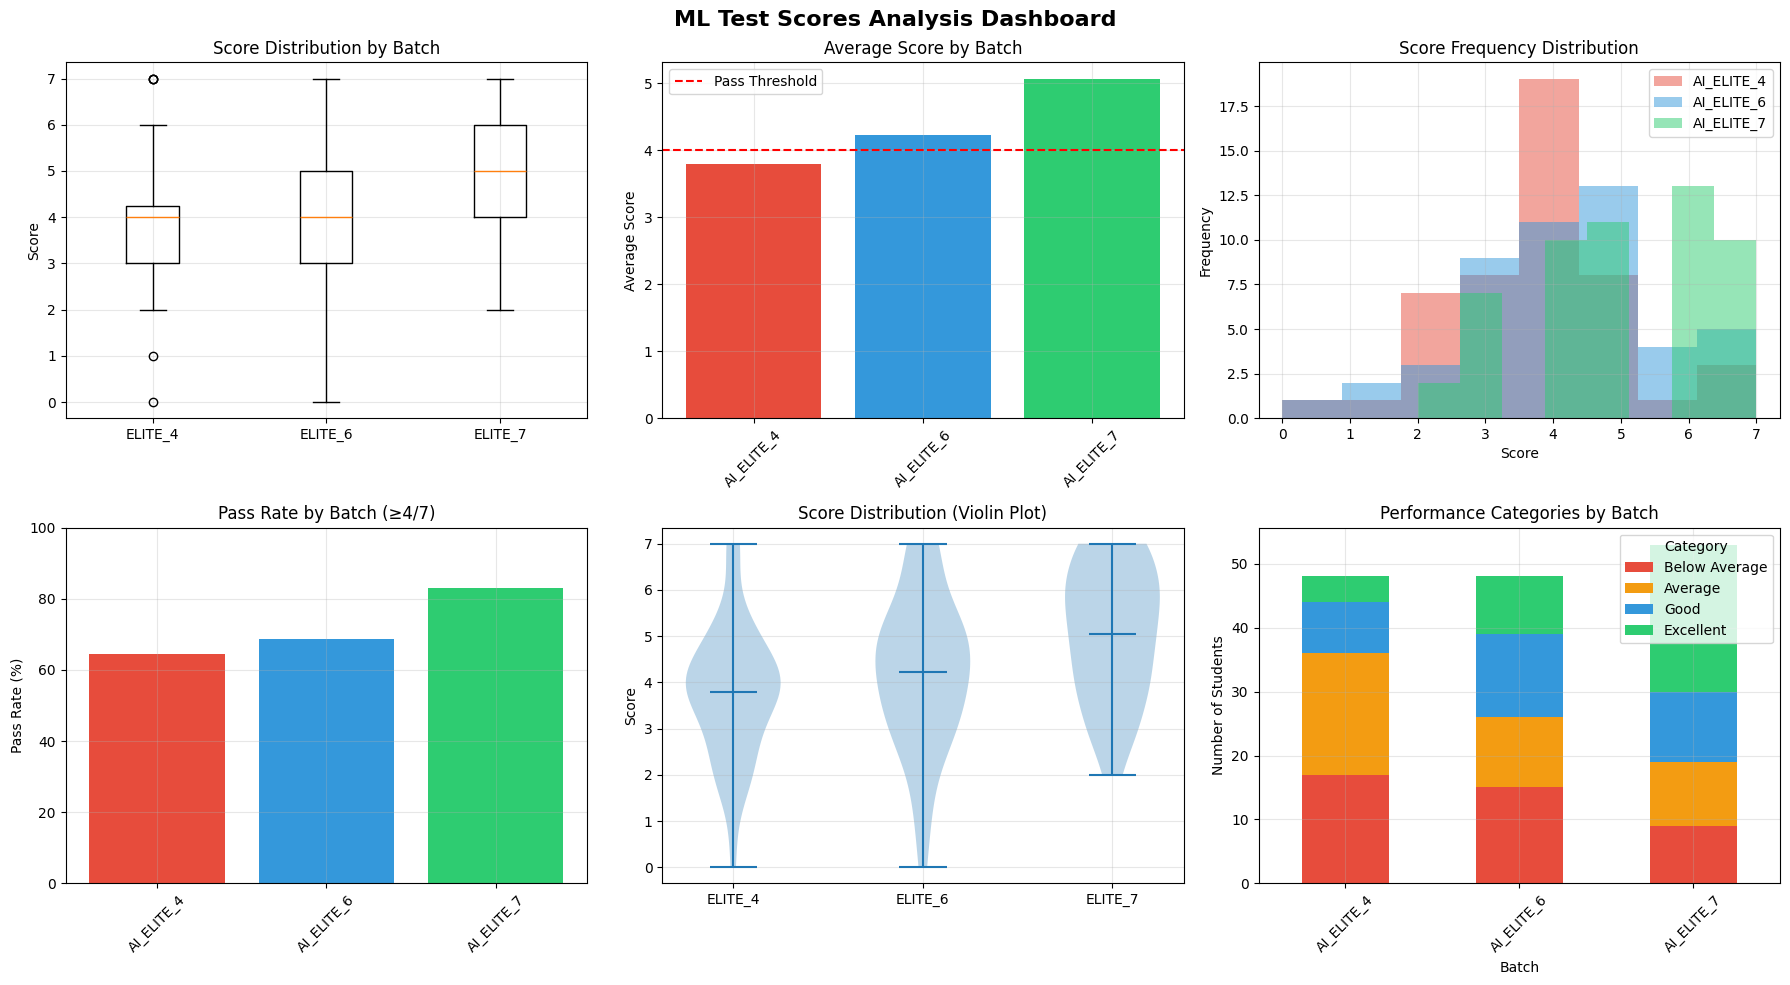

In [24]:
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('ML Test Scores Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Box plot
axes[0, 0].boxplot([batch4, batch6, batch7], labels=['ELITE_4', 'ELITE_6', 'ELITE_7'])
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Score Distribution by Batch')
axes[0, 0].grid(True, alpha=0.3)

# 2. Bar chart of means
means = df.groupby('Batch')['numeric_score'].mean()
axes[0, 1].bar(range(len(means)), means.values, color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0, 1].set_xticks(range(len(means)))
axes[0, 1].set_xticklabels(means.index, rotation=45)
axes[0, 1].set_ylabel('Average Score')
axes[0, 1].set_title('Average Score by Batch')
axes[0, 1].axhline(y=4, color='red', linestyle='--', label='Pass Threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Histogram
for batch, color in zip(['AI_ELITE_4', 'AI_ELITE_6', 'AI_ELITE_7'], 
                        ['#e74c3c', '#3498db', '#2ecc71']):
    batch_scores = df[df['Batch'] == batch]['numeric_score']
    axes[0, 2].hist(batch_scores, bins=8, alpha=0.5, label=batch, color=color)
axes[0, 2].set_xlabel('Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Score Frequency Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Pass rate comparison
pass_rates = df.groupby('Batch')['pass'].mean() * 100
axes[1, 0].bar(range(len(pass_rates)), pass_rates.values, 
               color=['#e74c3c', '#3498db', '#2ecc71'])
axes[1, 0].set_xticks(range(len(pass_rates)))
axes[1, 0].set_xticklabels(pass_rates.index, rotation=45)
axes[1, 0].set_ylabel('Pass Rate (%)')
axes[1, 0].set_title('Pass Rate by Batch (≥4/7)')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].grid(True, alpha=0.3)

# 5. Violin plot
parts = axes[1, 1].violinplot([batch4, batch6, batch7], 
                               positions=[0, 1, 2], showmeans=True)
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(['ELITE_4', 'ELITE_6', 'ELITE_7'])
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Score Distribution (Violin Plot)')
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance category stacked bar
category_counts = pd.crosstab(df['Batch'], df['performance_category'])
category_counts = category_counts[['Below Average', 'Average', 'Good', 'Excellent']]
category_counts.plot(kind='bar', stacked=True, ax=axes[1, 2], 
                     color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'])
axes[1, 2].set_ylabel('Number of Students')
axes[1, 2].set_title('Performance Categories by Batch')
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45)
axes[1, 2].legend(title='Category', loc='upper right')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()